In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
rcParams.update({'font.size':16})


import numpy as np
from ipywidgets import widgets
import matplotlib.pyplot as plt

from mpmath import mp
mp.dps = 50

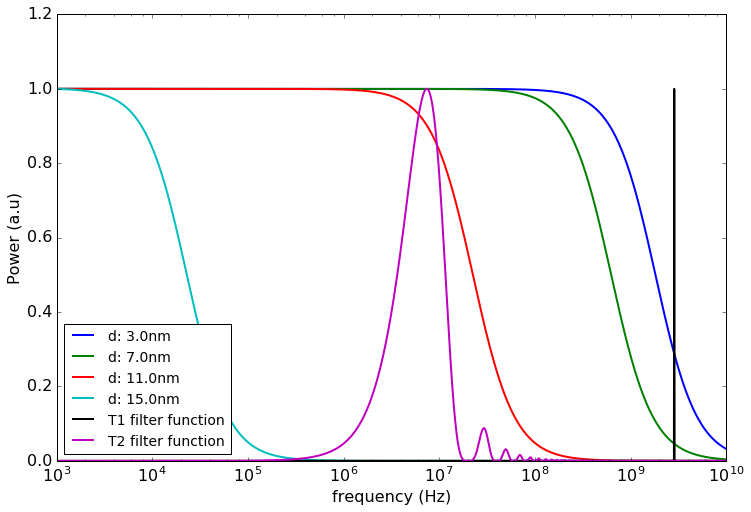

In [8]:
# K_b*T at RT is 4.04*10**-21 J

def spec(f,k,V,t,T):
    t_n = t*np.exp(k*V/(4.04*10**-21*(T/298.)))
    return (2 * t_n)/(np.pi* (1+np.square(t_n*f)))

def F1(f,b,T2):
    w_p = 2.865E9 + 28E6*b
    w_n = 2.865E9 - 28E6*b
    k = 1/T2
    return (1/np.pi)*( k/(k**2 + np.square(f-w_p)) + k/(k**2 + np.square(f-w_n)))

def F2(f,tau):
    return (1/(4*np.pi**2)) * (2/tau) * np.sin(2*np.pi*tau*f/4.)**4 / (f/4.)**2
    
f = np.logspace(3,10,2000)
t = 10**-9.3
k = 26E3

for r in (1.5,3.5,5.5,7.5):
    V = (4/3.0)*np.pi*(r*10**-9)**3
    T2 = 500E-9
    plt.semilogx(f,spec(f,k,V,t,298)/np.max(spec(f,k,V,t,298)),linewidth=2,label = "d: %snm"%(2*r))

plt.semilogx(f,F1(f,0,1E-6)/np.max(F1(f,0,1E-6)),'k',linewidth=2,label = "T1 filter function")
plt.semilogx(f,F2(f,1E-7)/np.max(F2(f,1E-7)),linewidth=2,label = "T2 filter function")
plt.legend(loc=3,fontsize=14)
plt.xlabel('frequency (Hz)')
plt.ylabel('Power (a.u)')
plt.ylim([0,1.2])
plt.show()


In [4]:
def spec(f,k,V,t):
    t_n = t*mp.exp(k*V/(mp.mpf(4.04*10**-21)))
    return mp.mpf((2 * t_n)/(mp.pi*(1+mp.power(2,t_n*f))))

def F1(f,b,T2):
    w_p = mp.mpf(2.865E9 + 28E6*b)
    w_n = mp.mpf(2.865E9 - 28E6*b)
    k = mp.mpf(1/T2)
    return mp.mpf((1/mp.pi)*( k/(k**2 + mp.power(f-w_p,2)) + k/(k**2 + mp.power(f-w_n,2))))

def F2(f,tau):
    return (1/(4*mp.pi**2)) * (2/tau) * mp.sin(2*mp.pi*tau*f/4.)**4 / (f/4.)**2

def T1_pred(b,r,b_v):
    k =  mp.mpf(26E3)
    t =  mp.mpf(10**-9.2)
    T1 = mp.mpf(20*1E-6)
    T2 = mp.mpf(1000*1E-9)
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    w_p = mp.mpf(2.865E9 + 28E6*b)
    w_n = mp.mpf(2.865E9 - 28E6*b)
    i = lambda f: F1(f,b,T2)*spec(f,k,V,t)
    S = mp.quad(i,[1E8,w_n-1E8,w_n+1E8,w_p-1E8,w_p+1E8,1E10])
    G_ext = mp.mpf(28E6**2*b_v**2*S)
    return mp.mpf(1/(1/T1+G_ext))

def T2_pred(tau,r,b_v):
    k =  mp.mpf(26E3)
    t =  mp.mpf(10**-9.2)
    T1 = mp.mpf(20*1E-6)
    T2 = mp.mpf(1000*1E-9)
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    i = lambda f: F2(f,tau*2)*spec(f,k,V,t)
    S = mp.quad(i,[1E4,1/tau-1E6,1/tau+1E6,1E8])
    G_ext = mp.mpf(28E6**2*b_v**2*S)
    return mp.mpf(1/(1/T2+G_ext))


b_v = 2.8
R = np.arange(1,15,0.1)
T1 = list( T1_pred(0,r,b_v*(r/3.5))/20E-6 for r in np.nditer(R))
T2 = list( T2_pred(1E-7,r,b_v*(r/3.5))/1E-6 for r in np.nditer(R))

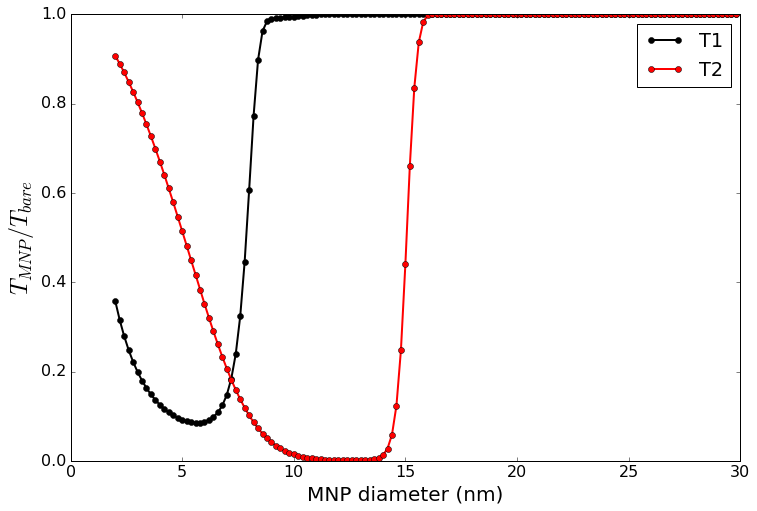

In [74]:
plt.plot(R*2,T1,'k-o',linewidth=2,label='T1')
plt.plot(R*2,T2,'r-o',linewidth=2,label='T2')
plt.xlabel("MNP diameter (nm)",fontsize=20)
plt.ylabel("$T_{MNP} / T_{bare} $",fontsize=24)
plt.legend()
plt.show()


In [5]:
def f(T1,t):
    return mp.mpf(2*T1/t**2*(t-T1+T1*mp.exp(-t/T1)))

def SE(tau,T1,B):
    return mp.exp( -((28E6)**2 * B**2 * tau**2 * f(T1,tau)/2.) )

def SE_pred(k,t,b_var,tau,r):
    V =  mp.mpf(4/3.0*np.pi*(r*1E-9)**3)
    t_n = mp.mpf(t*mp.exp(k*V/(4.04E-21)))
    #T2 = T2_pred(tau,r,b_var)
    return SE(tau,t_n,b_var)

b_v = 2.8
R = np.arange(1,10,0.1)
T2 = list( mp.exp(-2E-7/T2_pred(2E-7,r,b_v*(r/3.5))) for r in np.nditer(R))
S = list( SE_pred(26E3,10**-9.2,b_v*(r/3.5),1E-7,r) for r in np.nditer(R))
C = list(t-t*s for t,s in zip(T2,S))

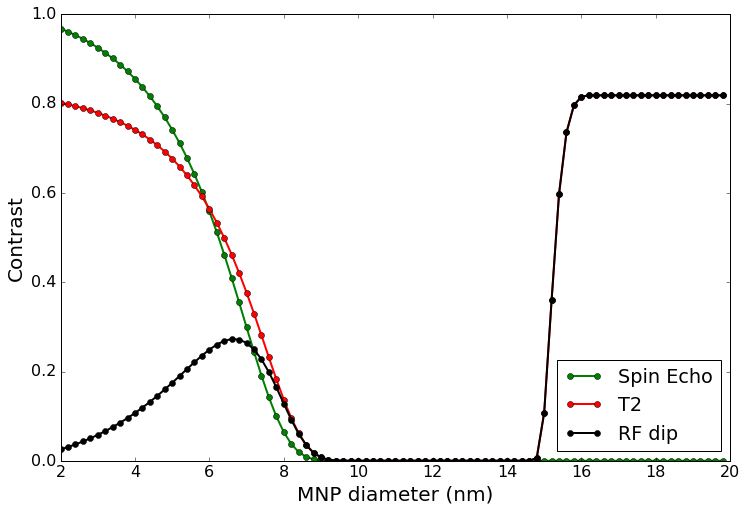

In [8]:
C = list(t-t*s for t,s in zip(T2,S))
plt.plot(2*R,S,'g-o',label="Spin Echo",linewidth=2)
plt.plot(2*R,T2,'r-o',label="T2",linewidth=2)
plt.plot(2*R,C,'k-o',label="RF dip",linewidth=2)
plt.xlabel("MNP diameter (nm)",fontsize=20)
plt.ylabel("Contrast",fontsize=20)
plt.legend(loc=4)
plt.show()